## Background
Failed inspections directly impact businesses that give loans to or partner with these companies.  Businesses include food delivery services (DoorDash, Grubhub).

Since the city of Chicago tracks [restaurant inspections](https://data.cityofchicago.org/Health-Human-Services/Restaurant/5udb-dr6f) since 2010, I decided to use this open souce data to generate a model that will predict whether or not a Chicago restaurant will failt is next inspection.


We'd like to generate a model that will predict whether or not a Chicago restaurant will fail its next inspection.


#### Determining the Target variable

We want to predict whether or not a Chicago restaurant will fail its next inspection.  Therefore the target variable is **Result**.  The results fall under three categories, after we ignore the others as they do not give valuable information to whether a restaurant failed or not, 'Pass', 'Pass w/ Conditions', and 'Fail'.

#### Choosing features

There are esentially 3 main features that we would like to look into.

**Zip**: This allows us to section Chicago into different neighborhoods.  Some neighborhoods may be more likely to fail or pass with Conditions for their inspection.

**Chains**:  More popular restaurants will have more chain restaurants and are possibly less likely to fail in their inspections.

**n_inspections, n_passed, n_failed, n_pwc**:  These numbers give us the number of previous inspections.  How often the restaurants passed, failed, or pwc'ed.  These numbers don't count the result from the most recent inspeciton.

#### Not good features
**Risk**:  While a convenient metric to see whether the inspection will pass or not, varies too much from inspection to inspection.

**Inspection Type**:  This along with Risk are not good features to use because the inspection type is random, which brings along with it the Risk.  We are more interested in the results from any kind of inspection.

### Data Cleaning and Aggregation

In [1]:
#Importing basic packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df2 = pd.read_csv('datasets/chicago_restaurant_inspections.csv')

In [4]:
df2.head()

,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,MANOLO'S TAMALES #3,MANOLO'S TAMALES #3,2307811,Restaurant,Risk 1 (High),2455 S KEDZIE AVE,CHICAGO,IL,60623.0,12/04/2018,Complaint Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.846539,-87.704953,"(41.846538888991475, -87.70495285575998)"
1,WOLFGANG EXPRESS,WOLFGANG PUCK EXPRESS (T3 K12),34199,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,60666.0,03/26/2019,Canvass,Fail,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,42.008536,-87.914428,"(42.008536400868735, -87.91442843927047)"
2,PASTORAL,BAR PASTORAL,2157189,Restaurant,Risk 1 (High),2945-2947 N BROADWAY AVE,CHICAGO,IL,60657.0,08/02/2019,Canvass,Pass w/ Conditions,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.936248,-87.644121,"(41.93624830273888, -87.64412091275041)"
3,JIEYI SUSHI,JIEYI SUSHI,2506880,Restaurant,Risk 1 (High),1178 N MILWAUKEE AVE,CHICAGO,IL,60642.0,06/25/2019,Canvass Re-Inspection,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.903119,-87.666337,"(41.90311911873191, -87.6663365256722)"
4,GHAREEB NAWAZ RESTAURANT,GHAREEB NAWAZ RESTAURANT,2423912,Restaurant,Risk 1 (High),2032-2036 W Devon AVE,CHICAGO,IL,60659.0,04/02/2019,Suspected Food Poisoning,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.997984,-87.681420,"(41.99798375025185, -87.68142044788961)"


In [6]:
#Some names were in all caps, some weren't, e.g. SUBWAY vs. Subway
#Make it all lowercase
df2['DBA Name'] = df2['DBA Name'].str.lower()

One of the results for inspection is 'Out of Business.'  Assuming that this is the last result for the restaurant, then, I don't want to consider all of the previous inspections, as I will not be predicting whether that restaurant will fail or not.

In [7]:
#Making a bool whether the restaurant went out of business
oob_bool = df2['Results']=='Out of Business'

In [8]:
#Change to DateTimeIndex
df2['Inspection Date'] = pd.to_datetime(df2['Inspection Date'])

In [9]:
#Drop the values of the previous inspections for restaurants that went out of business
for i, j, k in zip(df2['License #'][oob_bool], df2['Inspection Date'][oob_bool], df2['DBA Name'][oob_bool]):
    oob_bool2 = (df2['License #']==i) & (df2['Inspection Date'] <= j) & (df2['DBA Name'] == k)
    df2 = df2.drop(index=df2[oob_bool2].index.values)

In [10]:
#Check null values
df2.isnull().sum()

DBA Name               0
AKA Name             291
License #              0
Facility Type          0
Risk                   1
Address                0
City                  34
State                 18
Zip                    7
Inspection Date        0
Inspection Type        0
Results                0
Violations         13696
Latitude             110
Longitude            110
Location             110
dtype: int64

In [11]:
df2.describe()

,License #,Zip,Latitude,Longitude
count,7.490800e+04,74901.000000,74798.000000,74798.000000
mean,1.653433e+06,60628.871510,41.891986,-87.676280
std,9.026595e+05,19.831936,0.073465,0.062386
min,0.000000e+00,60601.000000,41.644670,-87.914428
25%,1.273140e+06,60612.000000,41.865020,-87.702813
50%,2.008835e+06,60625.000000,41.895544,-87.661709
75%,2.341038e+06,60644.000000,41.943015,-87.633714
max,2.712666e+06,60827.000000,42.020808,-87.525094


In [12]:
#Considering we have 7.4e4 we can afford to drop these values
#Drop latitude, longitude, and location, as there values don't affect us for the features we're using
df2 = df2.dropna(subset=['Latitude'])
#Drop the 7 Zip rows too
df2 = df2.dropna(subset=['Zip'])

Since we have three possible results now, we can perform a one-hot encoding, since they are categorical variables

In [13]:
#Create the columns for whether the inspeciton, passed, failed or pwc'ed
df2['Pwc'] = df2['Results'].copy()
df2['Passed'] = df2['Results'].copy()
df2['Failed'] = df2['Results'].copy()
df2['Pwc'][df2['Results']!='Pass w/ Conditions'] = 0
df2['Pwc'][df2['Results']=='Pass w/ Conditions'] = 1
df2['Passed'][df2['Results']!='Pass'] = 0
df2['Passed'][df2['Results']=='Pass'] = 1
df2['Failed'][df2['Failed']!='Fail'] = 0
df2['Failed'][df2['Failed']=='Fail'] = 1

/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel

Make an **aggregated** dataframe, based on a unique combination of features.  'License #' is not one of them.  But a combination of 'DBA Name' and 'Zip' gives a unique combination.  We then aggregate **n_inspections, n_passed, n_failed, n_pwc**.  We also grab the **most_recent_inspection** date to find the most recent result, as that will give us our labels

In [15]:
ln_df2 = (df2.groupby(['DBA Name','Zip'])
               .agg({'Inspection Type':'count', 'Passed':'sum', 'Failed':'sum', 'Inspection Date':'max','Pwc':'sum'})
               .reset_index()
               .rename(columns={'Inspection Type':'n_inspections','Pwc':'n_pwc', 'Passed':'n_passed', 'Failed':'n_failed', 'Inspection Date':'most_recent_inspection'})
        )

In [16]:
#Populate number of chain restaurants
ln_df2['Chains'] = [0] * len(ln_df2['DBA Name'])
#Restaurant Count
rc_df2 = ln_df2['DBA Name'].value_counts().reset_index().rename(columns={'index':'DBA Name', 'DBA Name':'Restaurant Counts'})
for i, j in zip(rc_df2['DBA Name'], rc_df2['Restaurant Counts']):
    ln_df2['Chains'][ln_df2['DBA Name'] == i] = j

/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
#Find most_recent_result
recent_pass = []
recent_fail = []
recent_pwc = []
for i, j, k in zip(ln_df2['Zip'], ln_df2['DBA Name'], ln_df2['most_recent_inspection']):
    df2_bool = (df2['Zip'] == i) & (df2['DBA Name'] == j) & (df2['Inspection Date'] == k)
    #print i,j,k
    #print(df2['Results'][df2_bool].index)
    #print(df2['Results'][df2_bool].values)[0]
   
    #print  df2['Result'][df2_bool].values[0]
    if df2['Results'][df2_bool].values[-1] == 'Pass':
        recent_pass.append(1)
        recent_fail.append(0)
        recent_pwc.append(0)
    elif df2['Results'][df2_bool].values[-1] == 'Fail':
        recent_pass.append(0)
        recent_fail.append(1)
        recent_pwc.append(0)
    elif df2['Results'][df2_bool].values[-1] == 'Pass w/ Conditions':
        recent_pass.append(0)
        recent_fail.append(0)
        recent_pwc.append(1)
    else:
        recent_pass.append(np.nan)
        recent_fail.append(np.nan)
        recent_pwc.append(np.nan)

In [18]:
ln_df2['recent_pass'] = recent_pass
ln_df2['recent_pwc'] = recent_pwc
ln_df2['recent_fail'] = recent_fail

In [19]:
#Last round of cleaning, these correspond to the results
#'No Entry' or other
ln_df2.isnull().sum()

DBA Name                    0
Zip                         0
n_failed                    0
n_pwc                       0
n_inspections               0
n_passed                    0
most_recent_inspection      0
Chains                      0
recent_pass               255
recent_pwc                255
recent_fail               255
dtype: int64

In [20]:
ln_df2 = ln_df2.dropna()

In [21]:
ln_df2.head()

,DBA Name,Zip,n_failed,n_pwc,n_inspections,n_passed,most_recent_inspection,Chains,recent_pass,recent_pwc,recent_fail
0,"""c"" a catering and event company",60634.0,1,0,11,8,2019-04-05,1,1.0,0.0,0.0
1,"""luna empanada shop""",60634.0,0,2,2,0,2020-01-14,1,0.0,1.0,0.0
3,#1 chop suey,60641.0,5,2,20,13,2020-01-24,1,0.0,0.0,1.0
4,"#1 chop suey restaurant, inc",60649.0,0,0,1,1,2019-10-22,1,1.0,0.0,0.0
5,1 2 3 express,60608.0,1,0,3,2,2011-11-23,1,1.0,0.0,0.0


In [22]:
#Need to subtract n_inspections, etc. by most recent result
fail_bool = ln_df2['recent_fail'] == 1
pass_bool = ln_df2['recent_pass'] == 1
pwc_bool = ln_df2['recent_pwc'] == 1
ln_df2['n_failed'][fail_bool] -= 1
ln_df2['n_inspections'][fail_bool] -=1
ln_df2['n_passed'][pass_bool] -= 1
ln_df2['n_inspections'][pass_bool]-=1
ln_df2['n_pwc'][pwc_bool] -=1
ln_df2['n_inspections'][pwc_bool] -=1

In [23]:
ln_df2.to_csv('datasets/chicago_restaurant_inspections_cleaned.csv')

### Training and Evaluating ML Model

In [24]:
#Since I'm using tensorflow, there's an error the occurs with MacOS and Jupyter Notebook
#The solution to which are the two lines
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [25]:
#Reinitialize df2
df2 = pd.read_csv('datasets/chicago_restaurant_inspections_cleaned.csv')

In [26]:
#Import tensorflow
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [27]:
#Define labels and features
features=['Zip', 'n_inspections','Chains','n_passed', 'n_failed', 'n_pwc']
labels = ['recent_pass','recent_fail','recent_pwc']

In [28]:
#Use a test size of 40%, and a specific random_state for reproducibility
y_val = df2[labels]
x_data = df2[features]
X_train, X_eval, y_train, y_eval = train_test_split(x_data, y_val, test_size=0.4, random_state=1)

In [29]:
#Normalize the features
X_train_stats = X_train.describe()
X_train_stats = X_train_stats.transpose()
def norm(x):
    return (x - X_train_stats['mean']) / X_train_stats['std']
normed_X_train = norm(X_train)
normed_X_eval = norm(X_eval)
normed_X_data = norm(x_data)

I decided to use a **neural network** with 2 hidden layers with 64 neurons each.  After each one, I decided to add a dropout to avoid overfitting.  Due to the nature of predictions, I use 'softmax' to output to one of the 3 possible outputs.  I used the Adam optimizer because it gave a higher accuracy with less amount of epochs.  **Accuracy** is what we will be using to evaluate how good the model is.

In [30]:
#Initialize NN model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 4,803
Trainable params: 4,803
Non-trainable params: 0
_________________________________________________________________
None


We perform training over 100 epochs, as after 3 or so epochs theres a non-insignificant increase in the accuracy.  We perform a validation split of 60/40.

In [32]:
model.fit(normed_X_train, y_train, epochs=100,validation_split=0.4, verbose=0)

In [33]:
#Evaluate how good the model is
train_pred = model.evaluate(normed_X_train, y_train)
test_pred = model.evaluate(normed_X_eval, y_eval)

3427/3427 [==============================] - 0s 35us/sample - loss: 0.7486 - accuracy: 0.6320


Higher accuracy on the training set, means that there could be some **overfitting**.  Now time to see the actual predictions.

### Results

In [35]:
predictions = model.predict(normed_X_data)
#These are mainly probabilities
df2['pred_pass'] = predictions[:,0]
df2['pred_fail'] = predictions[:,1]
df2['pred_pwc'] = predictions[:,2]

#Find the maximum probabilty
df2['pred_result'] = df2[['pred_pass', 'pred_fail','pred_pwc']].idxmax(axis=1)

#Get the result from the actual data
df2['recent_result'] = df2[['recent_pass', 'recent_fail', 'recent_pwc']].idxmax(axis=1)

In [36]:
rec_pwc_bool = (df2['recent_result'] == 'recent_pwc')
rec_pass_bool = (df2['recent_result'] == 'recent_pass')
rec_fail_bool = (df2['recent_result'] == 'recent_fail')
df2['recent_result'][rec_pwc_bool] = 'Pass w/ Conditions'
df2['recent_result'][rec_pass_bool] = 'Pass'
df2['recent_result'][rec_fail_bool] = 'Fail'

pred_pwc_bool = (df2['pred_result'] == 'pred_pwc')
pred_pass_bool = (df2['pred_result'] == 'pred_pass')
pred_fail_bool = (df2['pred_result'] == 'pred_fail')
df2['pred_result'][pred_pwc_bool] = 'Pass w/ Conditions'
df2['pred_result'][pred_pass_bool] = 'Pass'
df2['pred_result'][pred_fail_bool] = 'Fail'

/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/louispenafiel/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/louispenafiel/opt/anaconda2/lib/python

In [37]:
#Check accuracy score
from sklearn.metrics import accuracy_score

In [38]:
ml_accuracy = accuracy_score(df2['recent_result'], df2['pred_result'])
print(ml_accuracy)

0.6459670829928796


In [39]:
#Plot a confusion matrix
from sklearn.metrics import confusion_matrix

classes = ['Pass', 'Pass w/ Conditions', 'Fail']

In [40]:
confusion_matrix(df2['recent_result'], df2['pred_result'],labels=classes)

array([[1466, 2099,    0],
       [ 811, 4067,    0],
       [  64,   59,    1]])

To plot the confusion matrix, we use the below function from the [scikit-learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[1466 2099    0]
 [ 811 4067    0]
 [  64   59    1]]


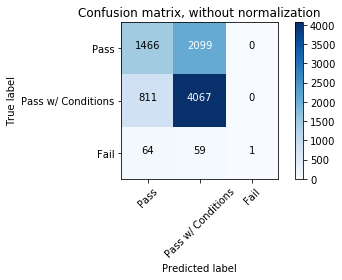

In [43]:
cnf_matrix = confusion_matrix(df2['recent_result'], df2['pred_result'],labels=classes)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix, without normalization')



A majority of the misclassification comes from predicting the inspection to be 'Pass w/ Conditions' when it should be 'Pass.'  Another misclassfication problem to look into is predictions for 'Fail.'  This could possibly be due to the data sets as a majority of the recent inspections are 'Pass' or 'Pass w/ Conditions.'  This means we need a better feature set.

Other features to look into include using the georgraphic separations (community areas of which [Chicago has 77 of](https://en.wikipedia.org/wiki/Community_areas_in_Chicago)) rather than Zip codes, as it is could be more coarse-grained (i.e. allowing for more 'Fail' restaurants in a specific region).  This would need a combination of geopy and geopandas to find get that information.

Another feature to take into consideration is **Inspection Date**, certain restaurants may operate differently depending on the time of year.

We can also alter the **Chains** feature to be changed into a binary classification with a specific threshold, like 3 restaurants with the same name.  As most non-chain restaurants have a value of 1, which can cause some fitting issues.

#### Other models looked into

One of the main models that I worked on was instead of using 'Pass w/ Conditions' I made that into 'Pass.'  However, that would give me around a 98% pass rate for the most recent inspection.  While this would give me a great accuracy (around 97% during testing and validating), I found that this is not a good enough understanding of how risky certain restaurants are in their follow-up inspection.  A restaurant passing with conditions is certainly riskier to include in the Rewards Network platform than a restaurant passing.  It is necessary to mitigate risk as much as possible as 'Pass W/ Conditions' does not give me confidence in the restaurant.